    Ben Christensen
    Math 345
    11/7/17

In [1]:
import numpy as np
from scipy import linalg as la
from scipy.misc import imread
from matplotlib import pyplot as plt
import scipy
from math import sqrt
import pdb

In [2]:
def laplacian(A):
    """Compute the Laplacian matrix of the graph G that has adjacency matrix A.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.

    Returns:
        L ((N,N) ndarray): The Laplacian matrix of G.
    """

    return np.diag(np.sum(A, axis=0)) - A


In [3]:
def connectivity(A, tol=1e-8):
    """Compute the number of connected components in the graph G and its
    algebraic connectivity, given the adjacency matrix A of G.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.
        tol (float): Eigenvalues that are less than this tolerance are
            considered zero.

    Returns:
        (int): The number of connected components in G.
        (float): the algebraic connectivity of G.
    """

    L = laplacian(A)
    lambs = np.real(la.eig(L)[0])
    print(lambs)
    mask = abs(lambs) < tol
    return len(mask * lambs) - len(np.nonzero(lambs)[0]), np.delete(lambs,np.argmin(lambs))[np.argmin(np.delete(lambs, np.argmin(lambs)))]


In [4]:
def get_neighbors(index, radius, height, width):
    """Calculate the flattened indices of the pixels that are within the given
    distance of a central pixel, and their distances from the central pixel.

    Parameters:
        index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
        radius (float): Radius of the neighborhood around the central pixel.
        height (int): The height of the original image in pixels.
        width (int): The width of the original image in pixels.

    Returns:
        (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
        (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
    """
    # Calculate the original 2-D coordinates of the central pixel.
    row, col = index // width, index % width

    # Get a grid of possible candidates that are close to the central pixel.
    r = int(radius)
    x = np.arange(max(col - r, 0), min(col + r + 1, width))
    y = np.arange(max(row - r, 0), min(row + r + 1, height))
    X, Y = np.meshgrid(x, y)

    # Determine which candidates are within the given radius of the pixel.
    R = np.sqrt(((X - col)**2 + (Y - row)**2))
    mask = R < radius
    return (X[mask] + Y[mask]*width).astype(np.int), R[mask]


In [5]:
class ImageSegmenter:
    """Class for storing and segmenting images."""

    # Problem 3
    def __init__(self, filename):
        """Read the image file. Store its brightness values as a flat array."""
        image = imread(filename)
        scaled = image / 255
        self.image = scaled
        if np.ndim(image) == 3:
            self.brightness = scaled.mean(axis=2)
        else:
            self.brightness = self.image
        self.flat = np.ravel(self.brightness)
    # Problem 3
    def show_original(self):
        """Display the original image."""
        if self.image.ndim < 3:
            plt.imshow(self.brightness, cmap="gray")
            plt.axis("off")
        else:
            plt.imshow(self.image)
            plt.axis("off")
        plt.show()
        
    def adjacency(self, r=5., sigma_B2=.02, sigma_X2=3.):
        """Compute the Adjacency and Degree matrices for the image graph."""
        A = scipy.sparse.lil_matrix((len(self.flat), len(self.flat)))
        m,n = A.shape
        l,k = self.brightness.shape
        for i in range(m):
            neighbors, distances = get_neighbors(i, r, l, k)
            B_dist = [abs(self.flat[i] - self.flat[neighbor]) for neighbor in neighbors]
            weights = [np.e**(-each/sigma_B2 - (distances[j] / sigma_X2)) for j, each in enumerate(B_dist)]
            A[i, neighbors] = weights
        d = np.ndarray.flatten(np.array(np.sum(A, axis=0)))
        return scipy.sparse.csc_matrix(A), d
    
    def cut(self, A, D):
        """Compute the boolean mask that segments the image."""
        L = scipy.sparse.csgraph.laplacian(A)
        #print(D)
        D_half = np.array([1 / sqrt(each) for each in D])
        D_half = scipy.sparse.diags(D_half)
        M = D_half @ L @ D_half
        val, vec = scipy.sparse.linalg.eigsh(M, which="SM", k=2)
        vec = vec[:, 1]
        vec = vec.reshape(self.brightness.shape)
        mask = vec > 0
        return mask
    
    def segment(self, r=5., sigma_B=.02, sigma_X=3.):
        """Display the original image and its segments."""
        A,d = self.adjacency(r, sigma_B, sigma_X)
        mask = self.cut(A, d)
        inv_mask = ~mask
        self.show_original()

        if self.image.ndim < 3:
            plt.subplot(131)
            plt.imshow(self.brightness, cmap="gray")
            plt.axis("off")
            plt.subplot(132)
            plt.imshow(self.image * mask, cmap="gray")
            plt.axis("off")
            plt.subplot(133)
            plt.imshow(self.image * inv_mask, cmap="gray")
            plt.axis("off")
        else:
            mask = np.dstack((mask, mask, mask))
            plt.subplot(131)
            plt.imshow(self.image)
            plt.axis("off")
            plt.subplot(132)
            plt.imshow(self.image * mask)
            plt.axis("off")
            plt.subplot(133)
            plt.imshow(self.image * ~mask)
            plt.axis("off")

        plt.show()

Segmenting dream_gray.png


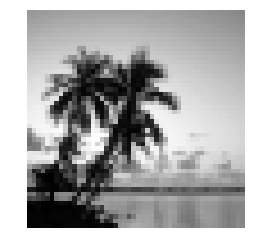

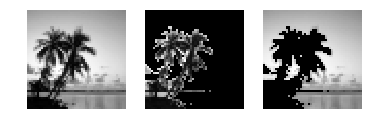

Segmenting dream.png


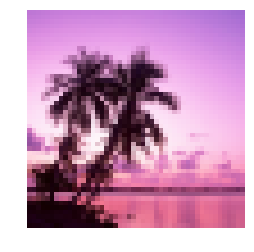

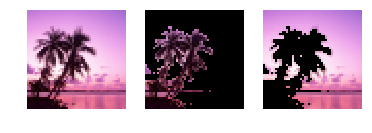

Segmenting monument_gray.png


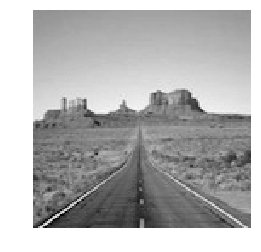

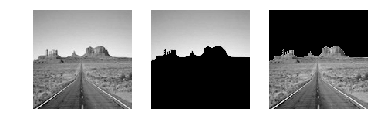

Segmenting monument.png


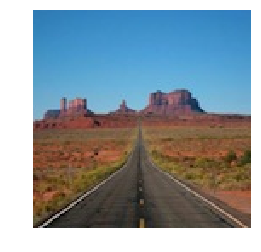

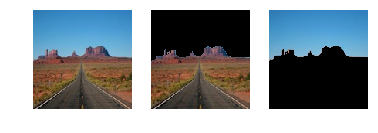

In [6]:
path = "/Users/benchristensen/Desktop/ACME Python Labs/Volume1-Student-Materials/ImageSegmentation/"
filenames = ["dream_gray.png", "dream.png", "monument_gray.png", "monument.png"]
for file in filenames:
    print("Segmenting", file)
    filename = path+file
    Segmenter = ImageSegmenter(filename)
    Segmenter.segment()